# Introduction

In [1]:
import librosa
import numpy as np
import transformers
import IPython.display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IPython.display.Audio(filename="/home/susnato/Music/The Lord of the Rings Main Theme Piano.mp3")

In [10]:
lotr, sr = librosa.load("/home/susnato/Music/The Lord of the Rings Main Theme Piano.mp3",
                        sr=44100)
print(sr)
print(len(lotr))
print(lotr)

44100
9817088
[0. 0. 0. ... 0. 0. 0.]


## waveform (Time domain representation)

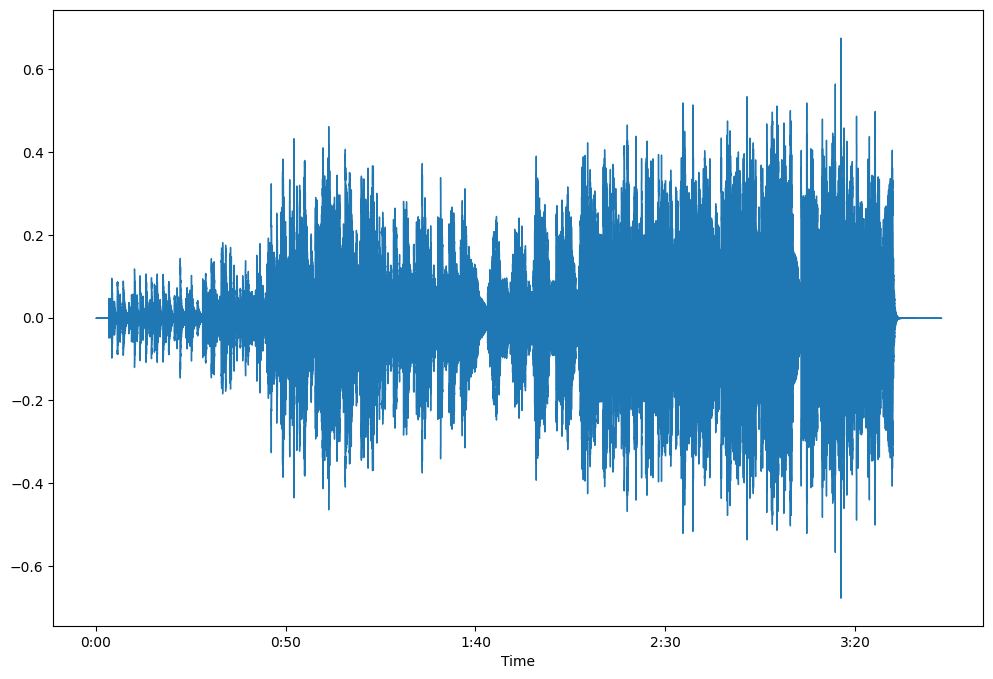

In [4]:
plt.figure(figsize=(12, 8))
librosa.display.waveshow(lotr, sr=sr)
plt.show();

## spectrum (Frequency domain representation)

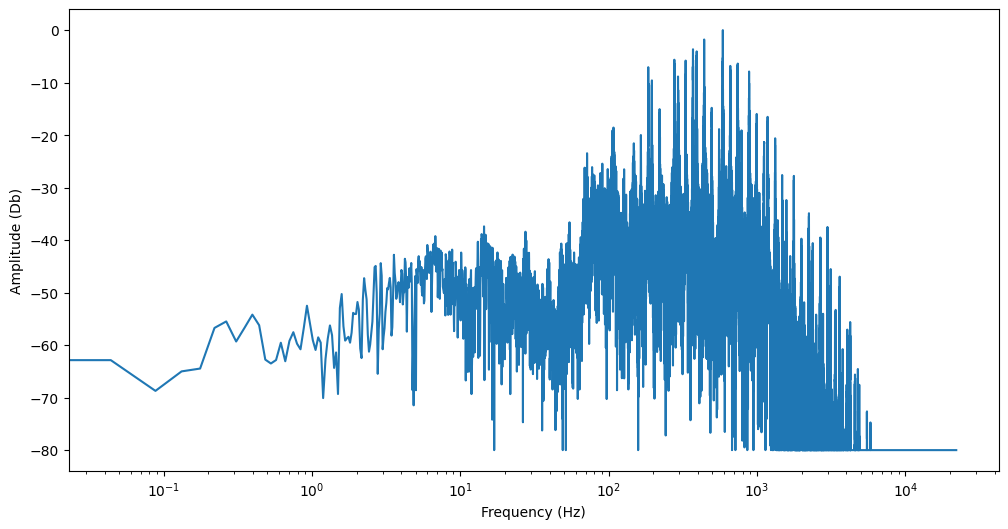

In [15]:
dft_ipt = lotr[:1_000_000]
window = np.hanning(len(dft_ipt))
windowed_ipt = window * dft_ipt
dft = np.fft.rfft(windowed_ipt)

amp = np.abs(dft)
amp_db = librosa.amplitude_to_db(amp, ref=np.max)
freq = librosa.fft_frequencies(sr=sr, n_fft=len(dft_ipt))

plt.figure(figsize=(12, 6))
plt.plot(freq, amp_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (Db)")
plt.xscale("log")
plt.show();

## Spectrogram (change in frequency over time)

Spectrum, Multiple spectrum = spectra, Spectra stacked together = Spectrogram

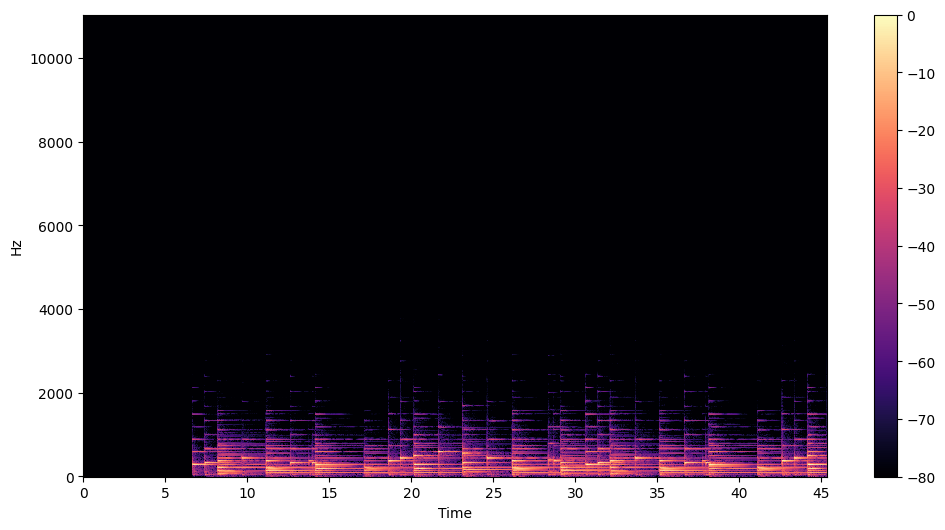

In [16]:
D = librosa.stft(dft_ipt)
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(D_db, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show();

## Mel-Spectogram
 log-mel spectrogram means that the mel spectrograms are converted from aplitude/power to Db
 which requires taking a `log`

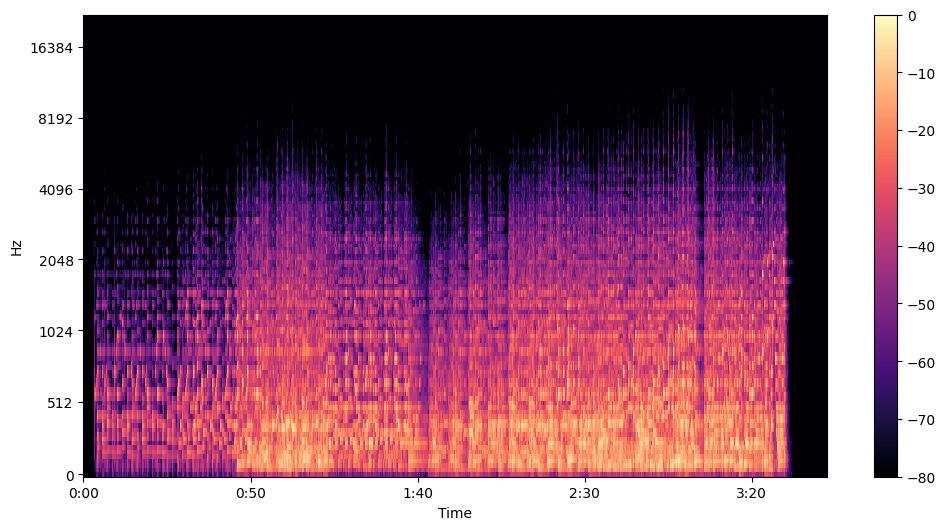

In [18]:
S = librosa.feature.melspectrogram(y=lotr, sr=sr, n_mels=128, fmax=22050)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, x_axis="time", y_axis="mel", sr=sr, fmax=22050)
plt.colorbar()
plt.show();

# HF Datasets

In [19]:
import gradio as gr
from datasets import load_dataset

In [20]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split='train')
print(minds)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /home/susnato/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.
Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})


In [21]:
minds[0]

{'path': '/home/susnato/.cache/huggingface/datasets/downloads/extracted/d56778fc83b1846293b2dc17ba84979b0e205cc50d1c104165147b2745eb1e4e/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/susnato/.cache/huggingface/datasets/downloads/extracted/d56778fc83b1846293b2dc17ba84979b0e205cc50d1c104165147b2745eb1e4e/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ], dtype=float32),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [27]:
minds = minds.remove_columns(["lang_id", "english_transcription"])

In [28]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [39]:
int2str = minds.features["intent_class"].int2str
print(minds[0]["transcription"])
print(int2str(minds[0]["intent_class"]))

I would like to pay my electricity bill using my card can you please assist
pay_bill


In [51]:
def get_example():
    audio = minds.shuffle()[0]
    int2str = minds.features["intent_class"].int2str
    return (audio["audio"]["sampling_rate"], audio["audio"]["array"]), \
        int2str(audio["intent_class"])

with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label =  get_example()
            output = gr.Audio(audio, label=label)
demo.launch()

/home/susnato/anaconda3/envs/transformers/lib/python3.9/site-packages/gradio/processing_utils.py:171: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


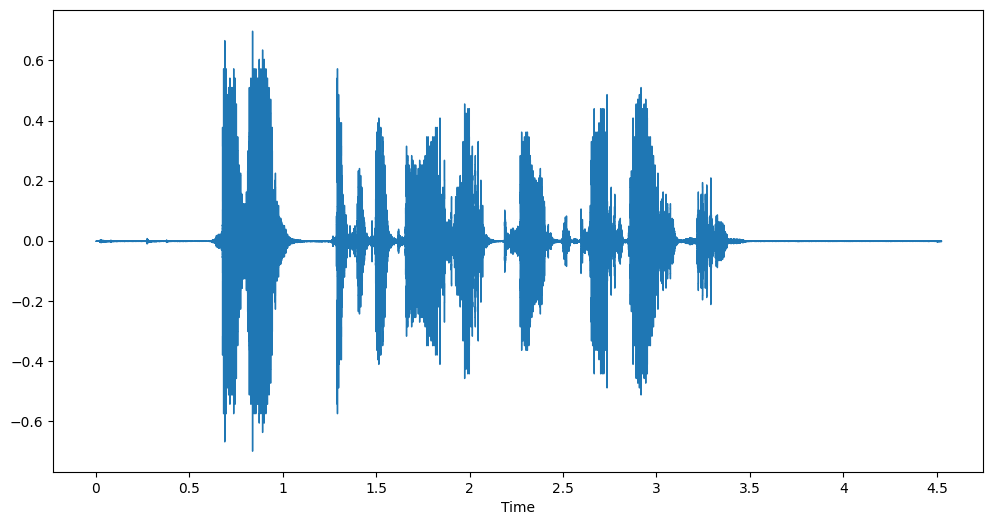

In [56]:
example = get_example()[0]
plt.figure(figsize=(12, 6))
librosa.display.waveshow(example[1], sr=example[0])
plt.show();

# Preprocessing

## Resampling

In [62]:
from datasets import Audio

minds_16 = minds.cast_column("audio", Audio(sampling_rate=16_000))

minds_16[0]

{'path': '/home/susnato/.cache/huggingface/datasets/downloads/extracted/d56778fc83b1846293b2dc17ba84979b0e205cc50d1c104165147b2745eb1e4e/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/susnato/.cache/huggingface/datasets/downloads/extracted/d56778fc83b1846293b2dc17ba84979b0e205cc50d1c104165147b2745eb1e4e/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.3611967e-05, 1.9232466e-04, 2.1928479e-04, ..., 9.4090728e-04,
         1.1661318e-03, 7.2088325e-04], dtype=float32),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [65]:
minds[0]['audio']['array'].shape, minds_16[0]['audio']['array'].shape

((62415,), (124830,))

## Filter

In [68]:
limit = 20.0

def filter_durations(input_durations):
    return input_durations<=limit

In [76]:
print(f"Before len : {len(minds_16)}")

durations = [librosa.get_duration(filename=i["audio"]["path"]) for i in minds_16]
minds_16 = minds_16.add_column("duration", durations)
minds_16 = minds_16.filter(filter_durations, input_columns=["duration"])
minds_16 = minds_16.remove_columns(["duration"])

print(f"After len : {len(minds_16)}")

Before len : 654


/tmp/ipykernel_10254/4156447956.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  durations = [librosa.get_duration(filename=i["audio"]["path"]) for i in minds_16]


  0%|          | 0/1 [00:00<?, ?ba/s]

After len : 624


## Post-processing

In [78]:
whisper_fe = transformers.WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
print(whisper_fe)

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}



In [82]:
def prepare_dataset(example):
    audio = example["audio"]
    return whisper_fe(raw_speech=audio["array"],
                      sampling_rate=audio["sampling_rate"],
                      padding=True,
                      )

In [85]:
minds_16 = minds_16.map(prepare_dataset)

  0%|          | 0/624 [00:00<?, ?ex/s]

In [89]:
minds_16[0].keys()

dict_keys(['path', 'audio', 'transcription', 'intent_class', 'input_features'])

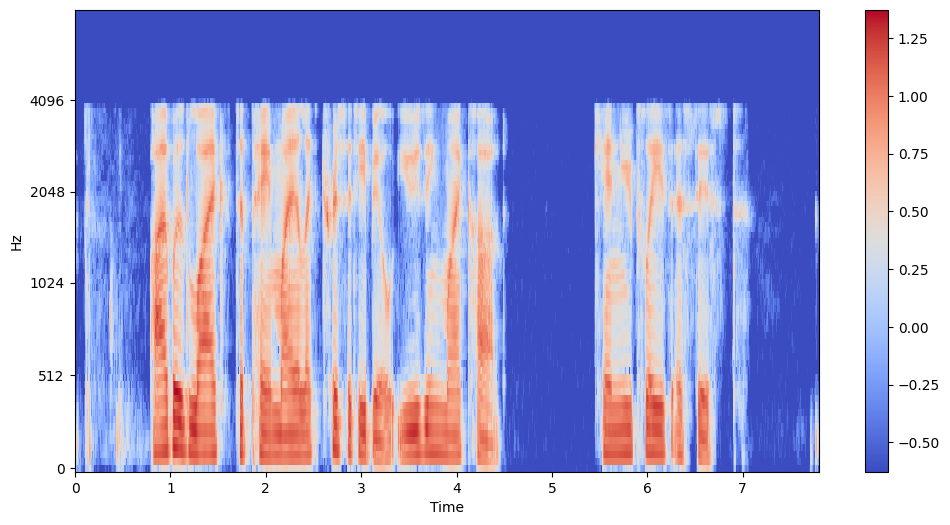

In [98]:
example = minds_16[0]

plt.figure(figsize=(12, 6))
librosa.display.specshow(np.array(example["input_features"][0]),
                         x_axis="time",
                         y_axis="mel",
                         sr=whisper_fe.sampling_rate,
                         hop_length=whisper_fe.hop_length
                        )
plt.colorbar()
plt.show();

# Streaming

In [105]:
gigaspeech = load_dataset(path="speechcolab/gigaspeech",
                          name="xs",
                          streaming=True)

In [107]:
gigaspeech

{'train': <datasets.iterable_dataset.IterableDataset at 0x7fe551484310>,
 'validation': <datasets.iterable_dataset.IterableDataset at 0x7fe55143a820>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x7fe55149f580>}

In [110]:
next(iter(gigaspeech["train"]))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}

In [112]:
[*gigaspeech["train"].take(2)]

[{'segment_id': 'YOU0000000315_S0000660',
  'speaker': 'N/A',
  'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
  'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
   'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
          0.00036621]),
   'sampling_rate': 16000},
  'begin_time': 2941.89,
  'end_time': 2945.07,
  'audio_id': 'YOU0000000315',
  'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
  'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
  'source': 2,
  'category': 24,
  'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'},
 {'segment_id': 'AUD0000001043_S0000775',
  'speaker': 'N/A',
  'text': 'SIX TOMATOES <PERIOD>',
  'audio': {'path': 'xs_chunks_0000/AUD0000001043_S0000775.wav',
   'array': array([ 1.43432617e-03,  1.37329102e-03,  1.31225586e-03, ...,
          -6.10351562e-05, -1.22070312e-04, -1.83105469e-04]),
   'sampling_rate': 16000},
 